In [1]:
#pip install keras

In [2]:
#pip install pandas_datareader

In [2]:
import math 
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
#prikazi floatove normalno, a ne u scientific formatu
pd.options.display.float_format = '{:.2f}'.format

In [4]:
df0 = pd.read_excel('trendETH1.xlsx',  header=0)

df0

,Unnamed: 0,Row Labels,Count of Posts,Sum of Voted Score,ETH open value,ETH close value,Promena,Znak,Prethodni Trend,Znak Prethodni,Buduca Promena,Znak Buduca
0,0,2020-12-01 00:00:00,2,0.00,616.65,605.63,-11.02,-1,0.00,0,1.70,1
1,1,2020-12-01 01:00:00,4,3.02,605.57,610.93,5.36,1,0.00,0,-5.58,-1
2,2,2020-12-01 02:00:00,1,0.00,611.00,611.07,0.07,1,0.00,0,-3.58,-1
3,3,2020-12-01 03:00:00,3,0.00,611.05,605.14,-5.91,-1,0.00,0,0.90,1
4,4,2020-12-01 04:00:00,1,0.00,604.97,603.59,-1.38,-1,0.00,0,0.06,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2775,2775,2021-04-30 20:00:00,4,0.43,2783.87,2761.67,-22.20,-1,1.97,1,0.00,0
2776,2776,2021-04-30 21:00:00,8,1.57,2761.67,2753.48,-8.19,-1,0.00,0,0.00,0
2777,2777,2021-04-30 22:00:00,5,1.60,2753.78,2745.44,-8.34,-1,-0.62,-1,0.00,0
2778,2778,2021-04-30 23:00:00,6,0.42,2745.36,2772.42,27.06,1,0.00,0,0.00,0


In [38]:
kolone = [ 'Row Labels', 'Sum of Voted Score', 'ETH close value']
df = df0[kolone]

# drop last 2 rows
df.drop(df.tail(2).index,inplace=True) 

#menjamo index 
df = df.set_index(pd.DatetimeIndex(df['Row Labels'].values))
del df['Row Labels']
df

C:\Users\hesh\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Sum of Voted Score,ETH close value
2020-12-01 00:00:00,0.00,605.63
2020-12-01 01:00:00,3.02,610.93
2020-12-01 02:00:00,0.00,611.07
2020-12-01 03:00:00,0.00,605.14
2020-12-01 04:00:00,0.00,603.59
...,...,...
2021-04-30 18:00:00,2.10,2775.99
2021-04-30 19:00:00,0.74,2783.86
2021-04-30 20:00:00,0.43,2761.67
2021-04-30 21:00:00,1.57,2753.48


In [58]:
#pravimo novi df samo sa close kolonom
#data = df.filter(['Sum of Voted Score', 'BTC close value'])

#konvertujemo df u numpy array
dataset = df.values

#broj redova na kojem cemo trenirati model
#koristimo 86% jer fale neki podaci u aprilu
training_data_len = math.ceil(len(dataset) * .7)
training_data_len 

1945

In [59]:
#skaliramo podatke (dobra praksa koja cesto olaksava treniranje NN)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# for i in range(0,25):
#     print(scaled_data[i])

<function matplotlib.pyplot.show(close=None, block=None)>

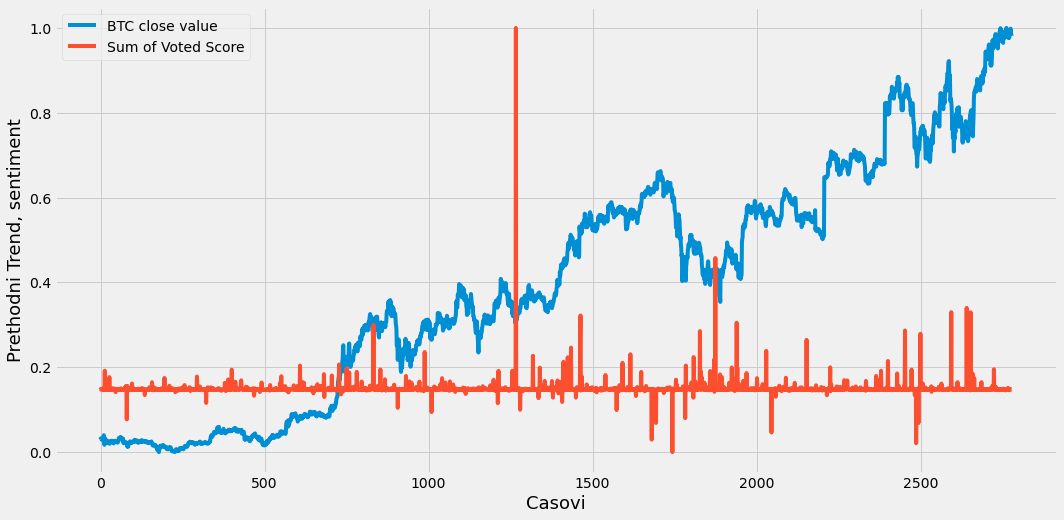

In [60]:
scaled_data_df = pd.DataFrame(scaled_data, columns = ['Sum of Voted Score', 'ETH close value'])
scaled_data_df

plt.figure(figsize=(16,8))
plt.plot(scaled_data_df['ETH close value'], label='BTC close value')
plt.plot(scaled_data_df['Sum of Voted Score'], label='Sum of Voted Score')
#plt.plot(scaled_data_df['Buduca Promena'].head(300), label='Buduca Promena')
plt.xlabel('Casovi',fontsize=18)
plt.ylabel('Prethodni Trend, sentiment', fontsize=18)
plt.legend()
plt.show

In [61]:
#pravimo data set za treniranje
#pravimo skaliran data set za treniranje
train_data = scaled_data[0:training_data_len, :]
#delimo podatke na x_train i y_train data set
x_train = []
y_train = []

# kolone redom: Sum of Voted Score, BTC close value, Prethodni Trend, Buduca Promena

# ovo je kod ako zelimo da uzimamo samo po jednu vrednost iz 'sentiment' i 'prethodni trend':
# for i in range(24, len(train_data)):
#     x_train.append(train_data[i, 0:2])
#     y_train.append(train_data[i, 2])    
# x_train
# print(y_train)
# print()

# ovo je kod ako zelimo da uzimamo poslednjih 24 closea i 24 sentimenta (vremenske serije):
for i in range(0, len(train_data)-24):
    # -1 !!!!!!!!!!!!!
    x_train.append(train_data[i:i+24, 0:2])
    y_train.append(train_data[i+24, 1])
    if i<=25:
        print(x_train)
        print(y_train)
        print()


[array([[0.14710384, 0.02991358],
       [0.14893968, 0.03226968],
       [0.14710384, 0.03233192],
       [0.14710384, 0.02969575],
       [0.14710384, 0.0290067 ],
       [0.14710384, 0.03116276],
       [0.14710384, 0.02988246],
       [0.14710384, 0.03221189],
       [0.15006758, 0.03147839],
       [0.14663198, 0.03384338],
       [0.14710384, 0.03973363],
       [0.14673158, 0.03449242],
       [0.14985025, 0.01711951],
       [0.19185152, 0.02261412],
       [0.14839314, 0.03212743],
       [0.14738219, 0.0291623 ],
       [0.14830657, 0.02482796],
       [0.14814235, 0.02589043],
       [0.14732783, 0.02262745],
       [0.14684952, 0.02718851],
       [0.14883297, 0.0246457 ],
       [0.14910942, 0.02513025],
       [0.14710384, 0.0229253 ],
       [0.14872061, 0.02085815]])]
[0.024392303999146464]

[array([[0.14710384, 0.02991358],
       [0.14893968, 0.03226968],
       [0.14710384, 0.03233192],
       [0.14710384, 0.02969575],
       [0.14710384, 0.0290067 ],
       [0.14710

       [0.14145432, 0.02575706]])]
[0.024392303999146464, 0.024836851183384606, 0.021849494105304318, 0.021044863701833255, 0.019711222149118884, 0.021231573519213315, 0.024178921350712174, 0.026357202553479037, 0.02558813592474704, 0.02524583459288368, 0.02669950388534234, 0.02679730426587476, 0.02445898607678218, 0.024343403808880254, 0.023085335277486324, 0.022747479417465327, 0.02044027953126945, 0.022578551487454884, 0.024783505521276034, 0.025885982538186608, 0.025792627629496606, 0.026548357842701403, 0.025757063854757484, 0.026028237637142765]

[array([[0.14710384, 0.02991358],
       [0.14893968, 0.03226968],
       [0.14710384, 0.03233192],
       [0.14710384, 0.02969575],
       [0.14710384, 0.0290067 ],
       [0.14710384, 0.03116276],
       [0.14710384, 0.02988246],
       [0.14710384, 0.03221189],
       [0.15006758, 0.03147839],
       [0.14663198, 0.03384338],
       [0.14710384, 0.03973363],
       [0.14673158, 0.03449242],
       [0.14985025, 0.01711951],
       [0.1

In [62]:
#Convert the x_train and y_Train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(1921, 24, 2)

In [63]:
#LSTM neuronska mreza prima 3d podatke (broj slucajeva, broj timestepova, broj feature(atribute koje koristimo u predikciji, kod nas su to sentiment i prethodni trend))
#2D podatke prebacujemo u 3D
#np.reashape prima niz i novu strukturu
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))
x_train.shape

(1921, 24, 2)

In [99]:
# LSTM model
model=Sequential()

#dodajemo sloj od 50 neurona, vraca
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1],2)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))

In [100]:
#Kompajliranje modela
model.compile(optimizer='adam', loss='mean_squared_error')

In [111]:
#Treniranje modela
model.fit(x_train,y_train, batch_size=10, epochs=10)

Epoch 1/10
193/193 [==============================] - 3s 15ms/step - loss: 1.3190e-04
Epoch 2/10
193/193 [==============================] - 3s 15ms/step - loss: 1.3180e-04
Epoch 3/10
193/193 [==============================] - 3s 14ms/step - loss: 1.2844e-04:
Epoch 4/10
193/193 [==============================] - 3s 14ms/step - loss: 1.2205e-04: 0s - loss: 1.2220e-
Epoch 5/10
193/193 [==============================] - 3s 15ms/step - loss: 1.0953e-04
Epoch 6/10
193/193 [==============================] - 3s 14ms/step - loss: 1.4691e-04: 1s  - ETA: 0s - loss: 1.
Epoch 7/10
193/193 [==============================] - 3s 15ms/step - loss: 1.2140e-04
Epoch 8/10
193/193 [==============================] - 3s 15ms/step - loss: 1.2057e-04
Epoch 9/10
193/193 [==============================] - ETA: 0s - loss: 9.0471e-05- ETA: 0s - loss: - 3s 15ms/step - loss: 9.0667e-05
Epoch 10/10
193/193 [==============================] - 3s 15ms/step - loss: 9.7057e-05


In [112]:
# pravimo test data set
# pravimo novi niz koji sadrzi skalirane vrednosti od dana 2160 do 2699
test_data = scaled_data[training_data_len - 24: , :]


#pravimo data setove x_test i y_test
x_test = []
y_test = dataset[training_data_len: , 1 ]

for i in range(24, len(test_data)):
    x_test.append(test_data[i-24:i, 0:2])
    
y_test.shape


(833,)

In [113]:
#konvertujemo podatke u np array kako bi mogli da ih koristimo u LSTM modelu
x_test = np.array(x_test)
x_test.shape

(833, 24, 2)

In [114]:
#Reshape                     broj sekvenci,duzina sekvence(24),broj featura
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))
x_test.shape

(833, 24, 2)

In [115]:
# predikcija!!!
predictions = model.predict(x_test)

#scaler je 2D(sent, cena), a meni treba 1D(cena), zato pravim novi scaler_novi koji ce imati iste parametre kao scaler
scaler_novi = MinMaxScaler()
scaler_novi.min_, scaler_novi.scale_ = scaler.min_[1], scaler.scale_[1]

# odskaliranje 
predictions = scaler_novi.inverse_transform(predictions)
# matricu konvertujemo u niz
predictions = predictions.flatten()

#na grafu se vidi da predikcije uvek kaskaju za nekih 1500 za stvarnim vrednostima, zato pomeramo
#predictions_pomeren = predictions

In [116]:
y_test.shape

(833,)

In [117]:
# mean squared error (MSE) 
mse = np.sqrt(np.mean(predictions - y_test) **2)
mse


19.33343844373688

In [118]:
predictions

array([1502.4865, 1479.4277, 1492.2241, 1496.8583, 1482.5222, 1492.2539,
       1488.8375, 1471.5325, 1480.3971, 1484.4639, 1492.4756, 1646.965 ,
       1687.3087, 1690.9338, 1744.2637, 1737.9426, 1737.8951, 1744.7346,
       1766.6908, 1751.8984, 1754.9418, 1762.9379, 1793.4114, 1793.7114,
       1808.6427, 1805.346 , 1848.6105, 1836.816 , 1861.584 , 1862.5319,
       1867.9872, 1857.5189, 1862.3146, 1852.1013, 1833.9429, 1853.8129,
       1851.8523, 1846.9966, 1848.1001, 1827.3009, 1857.6849, 1852.5796,
       1853.2585, 1852.3092, 1836.9713, 1840.4421, 1849.1499, 1855.7634,
       1846.1195, 1865.2577, 1891.42  , 1891.7811, 1849.3417, 1816.5596,
       1798.6776, 1813.4756, 1824.0261, 1827.5762, 1827.618 , 1842.8857,
       1853.0726, 1838.5247, 1834.7361, 1839.4944, 1864.277 , 1864.5237,
       1853.029 , 1864.3876, 1874.0714, 1864.9806, 1860.3076, 1827.6403,
       1835.8379, 1852.434 , 1818.8582, 1801.0123, 1806.3861, 1822.0192,
       1824.5083, 1821.9279, 1801.1265, 1805.5963, 

<ipython-input-119-5de94147063f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


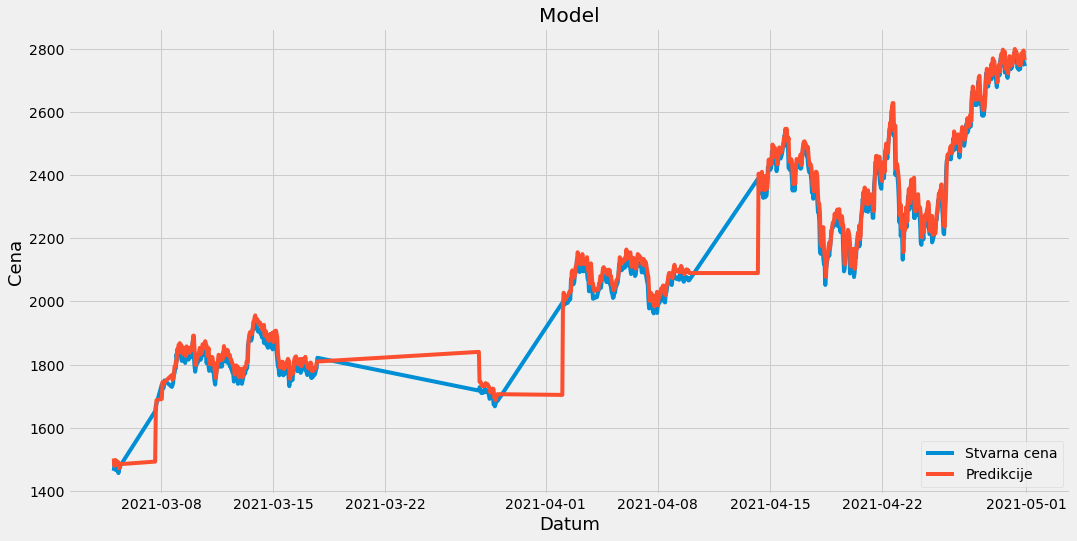

In [119]:
# podaci za graf
train = df[:training_data_len]
# dodajemo 104 dana jer toliko fali u aprilu
valid = df[training_data_len:]
valid['Predictions'] = predictions

# visualizacija
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Cena', fontsize=18)
#plt.plot(train['ETH close value'])
plt.plot(valid[['ETH close value', 'Predictions']])
plt.legend(['Stvarna cena','Predikcije'], loc='lower right')
plt.show()

In [120]:
valid

,Sum of Voted Score,ETH close value,Predictions
2021-03-05 01:00:00,0.64,1463.28,1502.49
2021-03-05 02:00:00,22.42,1480.97,1479.43
2021-03-05 03:00:00,0.97,1481.67,1492.22
2021-03-05 04:00:00,2.08,1465.48,1496.86
2021-03-05 06:00:00,-0.80,1479.99,1482.52
...,...,...,...
2021-04-30 18:00:00,2.10,2775.99,2769.92
2021-04-30 19:00:00,0.74,2783.86,2787.78
2021-04-30 20:00:00,0.43,2761.67,2795.23
2021-04-30 21:00:00,1.57,2753.48,2772.21
